In [1]:
random_seed = 1
import random
random.seed(random_seed)

import numpy as np
# set the random seed to make the experiment reproducible

np.random.seed(random_seed)

import tensorflow
# set seed
tensorflow.random.set_seed(random_seed)

2022-10-30 00:04:24.888678: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
from keras.utils import np_utils

# imblean provides tools for us to deal with imbalanced class sizes
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

# example of random oversampling to balance the class distribution
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from imblearn.over_sampling import ADASYN

import sklearn
assert sklearn.__version__ >= "0.20"

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [3]:
X_train_df = pd.read_excel('data/model_inputs/x_train_3perc.xlsx', index_col=0)
X_test_df = pd.read_excel('data/model_inputs/x_test_3perc.xlsx', index_col=0)
y_train_df = pd.read_excel('data/model_inputs/y_train_3perc.xlsx', index_col=0)
y_test_df = pd.read_excel('data/model_inputs/y_test_3perc.xlsx', index_col=0)

In [4]:
pd.DataFrame(y_train_df.reset_index()).groupby('decision').count()

,index
decision,
-1,147
0,1264
1,100


### Oversampling

In [5]:
def smote(X_train, y_train):
    sm = SMOTE(sampling_strategy='not majority')
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    return X_train_oversampled, y_train_oversampled

def random_oversampler(X_train, y_train):
    oversample = RandomOverSampler(sampling_strategy='not majority')
    X_over, y_over = oversample.fit_resample(X_train, y_train)
    return X_over, y_over

def adasyn(X_train, y_train):
    ada = ADASYN(sampling_strategy = 'not majority')
    X_resampled, y_resampled = ADASYN().fit_resample(X_train, y_train)
    return X_resampled, y_resampled

In [6]:
sm = smote(X_train_df, y_train_df)
sm[1].value_counts()

decision
-1          1264
 0          1264
 1          1264
dtype: int64

In [7]:
random_oversampling = random_oversampler(X_train_df, y_train_df)
random_oversampling[1].value_counts()

decision
-1          1264
 0          1264
 1          1264
dtype: int64

In [8]:
ada = adasyn(X_train_df, y_train_df)
ada[1].value_counts()

decision
 0          1264
 1          1258
-1          1235
dtype: int64

### Shuffle + Numpy Array

In [9]:
def shuffle_numpy_encode(X_train, X_test, y_train, y_test):
    # shuffle the dataset! 
    train_data = X_train.copy(deep=True)
    train_data['decision'] = y_train['decision']

    train_data = train_data.sample(frac=1)

    X_train = train_data.drop(['decision'], axis=1)
    y_train = pd.DataFrame(train_data['decision'])
    
    # convert to numpy arrays
    X_train = np.array(X_train).astype(dtype='float64')
    X_test = np.array(X_test).astype(dtype='float64')

    y_train = np.array(y_train['decision'])
    y_test = np.array(y_test['decision'])

    # one hot encode
    # y_train = np_utils.to_categorical(y_train, num_classes=3)
    # y_test = np_utils.to_categorical(y_test, num_classes=3)

    y_train = np.array(list(map(lambda x: 2 if x==-1 else x, y_train))).astype(dtype='uint8')
    y_test = np.array(list(map(lambda x: 2 if x==-1 else x, y_test))).astype(dtype='uint8')


    return X_train, X_test, y_train, y_test

In [10]:
def plot_curve(hist):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  epochs = hist.epoch
  f, ax = plt.subplots(ncols=2, figsize=(20,8))
  ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
  ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()
  ax[1].plot(epochs, hist.history['accuracy'], label='Training Accuracy')
  ax[1].plot(epochs, hist.history['val_accuracy'], label='Validation Accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].legend()

In [11]:
from tabnanny import verbose


def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(input_shape=(X_train_df.shape[1],), units=300, activation='relu'))
  model.add(tf.keras.layers.Dense(units=100, activation='relu'))
    # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))    
                           
  # # Construct the layers into a model that TensorFlow can execute.  
  # # Notice that the loss function for multi-class classification
  # # is different than the loss function for binary classification.  
  # model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
  #               loss="sparse_categorical_crossentropy", 
  #               metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate), loss="sparse_categorical_crossentropy", metrics=['accuracy'])

  return model    


def train_model(model, train_features, train_label, epochs,
                validation_data, batch_size=None):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_data=validation_data, verbose=0)
  
  return history   

### Train Model

In [12]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.1

# Establish the model's topography.
my_model = create_model(learning_rate)

2022-10-30 00:04:30.158385: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
results = pd.DataFrame(columns=['loss', 'accuracy'])

SMOTE Results

In [14]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(X_train_df, X_test_df, y_train_df, y_test_df)

In [15]:
X_valid = X_train[0:400]
X_train = X_train[400:]

y_valid = y_train[0:400]
y_train = y_train[400:]

In [16]:
sm = smote(X_train, y_train)
X_train = sm[0]
y_train = sm[1]

6/6 [==============================] - 0s 806us/step - loss: 3.1878 - accuracy: 0.5119


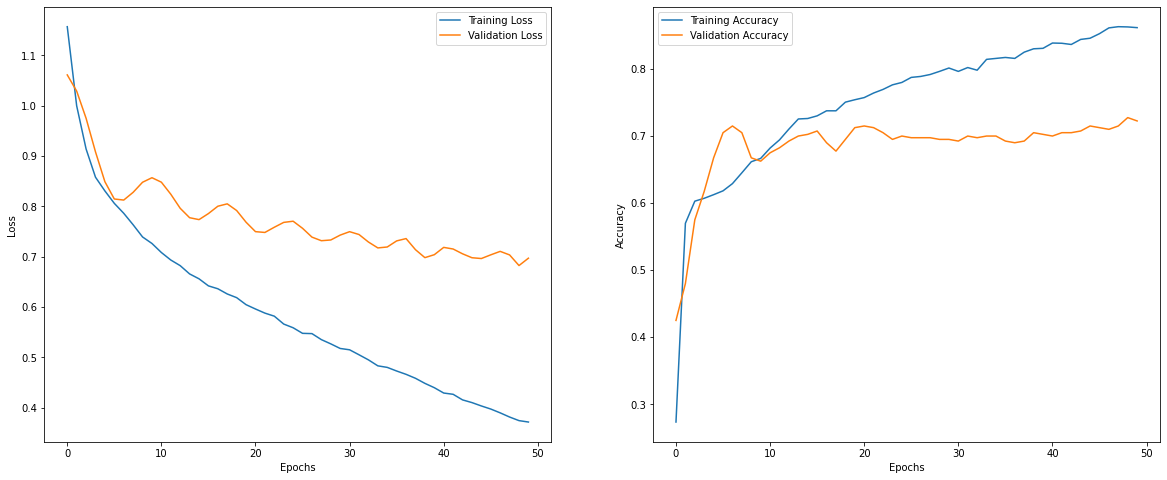

In [17]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, (X_valid, y_valid), batch_size)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# # Evaluate on Test & Save results
results.loc['smote'] = list(my_model.evaluate(X_test, y_test))

In [18]:
results

,loss,accuracy
smote,3.187829,0.511905


In [19]:
predict_x=my_model.predict(X_test) 
predictions=np.argmax(predict_x,axis=1)

6/6 [==============================] - 0s 720us/step


In [20]:
# check predictions
set(predictions)

{0, 1, 2}

In [21]:
#confusion matrix
sklearn.metrics.multilabel_confusion_matrix(
    np.array(y_test_df['decision']),
    predictions,
    labels=[0,1,2]
    # num_classes=3,
    # weights=None,
    # dtype=tf.dtypes.int32,
    # name=None
)

array([[[  4,  78],
        [  4,  82]],

       [[125,   0],
        [ 42,   1]],

       [[161,   7],
        [  0,   0]]])

In [22]:
sklearn.metrics.f1_score(y_test_df['decision'],predictions, average='weighted')

0.35290404040404033

Random Oversampling Results

In [20]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(random_oversampling[0], X_test_df, random_oversampling[1], y_test_df)

6/6 [==============================] - 0s 733us/step - loss: 3.1851 - accuracy: 0.5119


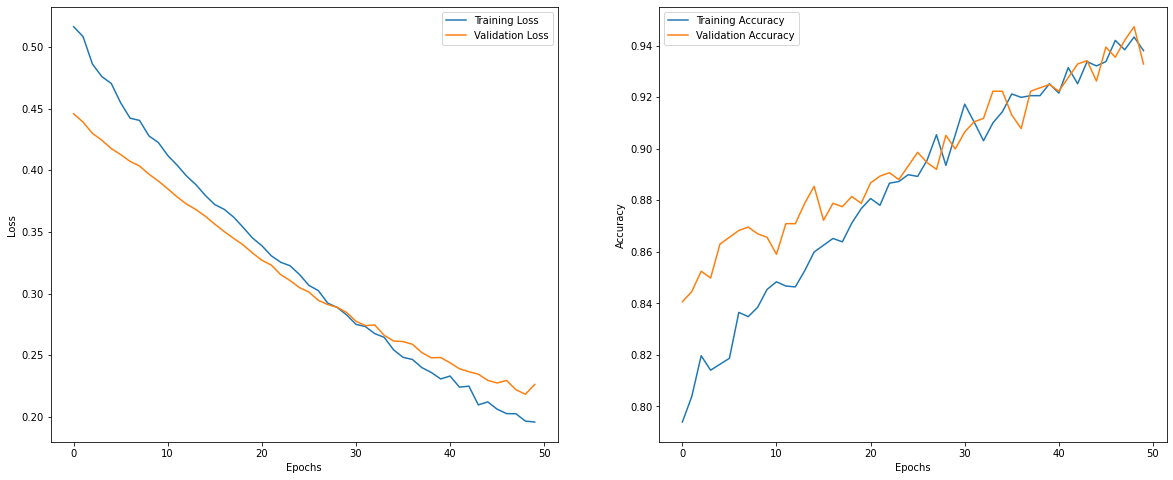

In [21]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# Evaluate on Test & Save results
results.loc['random_oversampling'] = list(my_model.evaluate(X_test, y_test))

ADASYN

In [22]:
X_train, X_test, y_train, y_test = shuffle_numpy_encode(ada[0], X_test_df, ada[1], y_test_df)

6/6 [==============================] - 0s 722us/step - loss: 5.6638 - accuracy: 0.5298


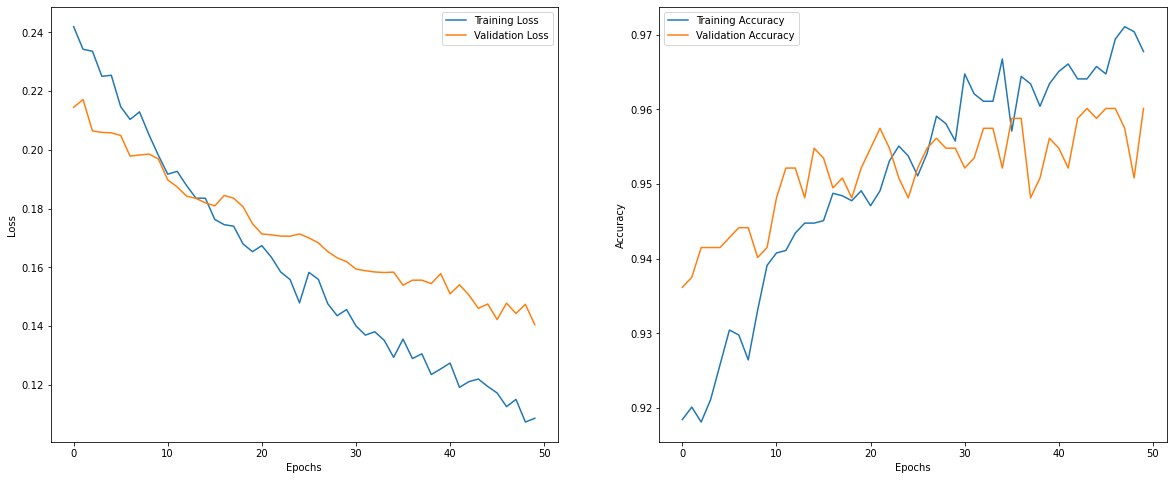

In [23]:
# Train the model on the normalized training set.
hist = train_model(my_model, X_train, y_train, epochs, batch_size, validation_split)
# Plot a graph of the metric vs. epochs.
plot_curve(hist)
# Evaluate on Test & Save results
results.loc['adasyn'] = list(my_model.evaluate(X_test, y_test))

### Results

In [ ]:
# # 3 percent
# results['f1'] = 2 * (results['precision'] * results['recall']) / (results['precision'] + results['recall'])
# results 

In [ ]:
# # 5 percent
# results['f1'] = 2 * (results['precision'] * results['recall']) / (results['precision'] + results['recall'])
# results 

### Tuning

In [25]:
#optimisation
from bayes_opt import BayesianOptimization

# model building
import keras
import tensorflow
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Embedding, SimpleRNN , concatenate, Lambda
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras import metrics
from keras.losses import BinaryCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import cross_val_score


def rnn_tuner2(C, batch_size, neurons1, neurons2, neurons3, activation, optimizer, dropout, dropout_rate, learning_rate, epochs, layers1, layers2):

    C = round(C, 3)
    optimizerL = ['SGD', 'Adam', 'RMSprop']
    optimizerD= {'Adam':Adam(learning_rate=learning_rate), 'SGD':SGD(learning_rate=learning_rate),
                  'RMSprop':RMSprop(learning_rate=learning_rate)}
    activationL = ['relu']
    neurons1 = round(neurons1)
    neurons2 = round(neurons2)
    neurons3 = round(neurons3)
    activation = activationL[round(activation)]
    optimizer = optimizerD[optimizerL[round(optimizer)]]
    batch_size = round(batch_size)
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)

    def create_model():
      tuned_model = Sequential()
      tuned_model.add(Dense(units=neurons1, input_shape = (X_train_df.shape[1],),kernel_regularizer=tf.keras.regularizers.l2(C))) #input_shape = (batch_size (1st dimension -> num_rows --> excluded), input_size (2nd dimension -> cols),input_dim (2-1))

      for i in range(layers1): #varying first set of hidden layers
          tuned_model.add(Dense(neurons2, activation=activation,kernel_regularizer=tf.keras.regularizers.l2(C)))

      if dropout > 0.5:
          tuned_model.add(Dropout(dropout_rate, seed=42))

      for i in range(layers2): #varying second set of hidden layers
          tuned_model.add(Dense(neurons3, activation=activation,kernel_regularizer=tf.keras.regularizers.l2(C)))

      tuned_model.add(Dense(3, activation='softmax')) #output layer

      tuned_model.compile(loss="sparse_categorical_crossentropy", optimizer = optimizer, metrics=['accuracy'])
     # tuned_model = tuned_model.fit(X_train_smenn, y_train_smenn, epochs=20)
     # tuned_model.summary()
      return tuned_model

    es = EarlyStopping(monitor="loss", patience=3)
    mc = ModelCheckpoint('Best_tuned_NN.h5', monitor='val_loss',mode='min',verbose=2, save_best_only=True)

    tune_rnn = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0) 
    score = cross_val_score(tune_rnn, X_train, y_train, fit_params={'callbacks':[es]}, error_score='raise').mean() #5 fold cross validation default
    return score


In [26]:
params_rnn2 ={
    'neurons1': (100, 500),
    'neurons2': (100, 500),
    'neurons3': (100, 500),
    'C': (0,1),
    'activation':(0,0),
    'optimizer':(0,2),
    'learning_rate':(0.001, 0.01),
    'batch_size':(100, 500),
    'epochs':(20, 50),
    'layers1':(1,3),
    'layers2':(1,3),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}

In [27]:
# Run Bayesian Optimization
rnn_bo2 = BayesianOptimization(rnn_tuner2, params_rnn2, random_state=42)
rnn_bo2.maximize(init_points=25, n_iter=4)

|   iter    |  target   |     C     | activa... | batch_... |  dropout  | dropou... |  epochs   |  layers1  |  layers2  | learni... | neurons1  | neurons2  | neurons3  | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 1         | 0.02688   | 0.3745    | 0.0       | 392.8     | 0.5987    | 0.04681   | 24.68     | 1.116     | 2.732     | 0.00641   | 383.2     | 108.2     | 488.0     | 1.665     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 2         | 0.02688   | 0.2123    | 0.0       | 173.4     | 0.3042    | 0.1574    | 32.96     | 1.582     | 2.224     | 0.002255  | 216.9     | 246.5     | 282.4     | 1.57      |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 3         | 0.03978   | 0.1997    | 0.0       | 337.0     | 0.04645   | 0.1823    | 25.12     | 1.13      | 2.898     | 0.009691  | 423.4     | 221.8     | 139.1     | 1.368     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 4         | 0.03978   | 0.4402    | 0.0       | 298.1     | 0.03439   | 0.2728    | 27.76     | 2.325     | 1.623     | 0.005681  | 318.7     | 173.9     | 487.8     | 1.55      |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 5         | 0.02975   | 0.9395    | 0.0       | 339.2     | 0.9219    | 0.02655   | 25.88     | 1.09      | 1.651     | 0.004498  | 208.5     | 431.5     | 242.7     | 0.5619    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 6         | 0.03262   | 0.5427    | 0.0       | 420.9     | 0.07455   | 0.2961    | 43.17     | 1.397     | 1.011     | 0.008339  | 382.7     | 391.6     | 408.5     | 0.1481    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 7         | 0.0491    | 0.3585    | 0.0       | 445.2     | 0.6233    | 0.09927   | 21.91     | 1.622     | 1.65      | 0.007566  | 355.0     | 454.9     | 288.9     | 0.2392    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 8         | 0.02688   | 0.7132    | 0.0       | 324.5     | 0.771     | 0.1481    | 35.68     | 1.855     | 1.051     | 0.001971  | 112.6     | 354.6     | 225.7     | 1.017     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 9         | 0.02688   | 0.9076    | 0.0       | 264.2     | 0.7556    | 0.06864   | 22.31     | 1.58      | 1.322     | 0.009367  | 423.2     | 353.4     | 448.6     | 1.607     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 10        | 0.03763   | 0.1866    | 0.0       | 315.7     | 0.8074    | 0.2688    | 29.54     | 1.22      | 1.456     | 0.004844  | 427.2     | 444.3     | 102.8     | 1.021     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 11        | 0.02688   | 0.4174    | 0.0       | 147.9     | 0.3376    | 0.2829    | 29.7      | 2.038     | 2.406     | 0.004273  | 488.7     | 485.0     | 200.7     | 0.9945    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 12        | 0.02688   | 0.3009    | 0.0       | 114.8     | 0.6096    | 0.1508    | 21.54     | 1.557     | 2.817     | 0.003156  | 158.0     | 295.8     | 494.3     | 0.4841    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 13        | 0.02688   | 0.6721    | 0.0       | 195.1     | 0.7282    | 0.1103    | 38.97     | 2.267     | 2.072     | 0.001813  | 434.1     | 228.3     | 174.6     | 0.08155   |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 14        | 0.02688   | 0.5909    | 0.0       | 106.6     | 0.5121    | 0.06795   | 39.36     | 1.349     | 2.382     | 0.004481  | 474.7     | 155.0     | 236.4     | 0.2269    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 15        | 0.02975   | 0.9247    | 0.0       | 203.2     | 0.66      | 0.2452    | 36.66     | 2.059     | 1.484     | 0.001838  | 458.9     | 460.2     | 353.2     | 0.6781    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 16        | 0.03978   | 0.3492    | 0.0       | 458.8     | 0.8871    | 0.234     | 39.26     | 1.168     | 1.323     | 0.009087  | 342.6     | 103.7     | 140.6     | 1.327     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 17        | 0.5935    | 0.005062  | 0.0       | 319.5     | 0.6919    | 0.1956    | 26.73     | 2.424     | 1.474     | 0.003929  | 398.6     | 359.9     | 439.7     | 1.315     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 18        | 0.02688   | 0.5683    | 0.0       | 247.1     | 0.2652    | 0.0732    | 49.19     | 1.786     | 2.784     | 0.00668   | 417.9     | 301.1     | 330.8     | 0.985     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 19        | 0.02975   | 0.1952    | 0.0       | 212.3     | 0.02432   | 0.1936    | 25.31     | 2.881     | 2.908     | 0.009234  | 248.1     | 106.2     | 471.3     | 0.8564    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 20        | 0.02688   | 0.9667    | 0.0       | 441.2     | 0.2944    | 0.1155    | 45.53     | 1.634     | 1.339     | 0.006011  | 474.5     | 378.4     | 328.0     | 0.1944    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 21        | 0.02688   | 0.615     | 0.0       | 156.0     | 0.5183    | 0.2632    | 42.22     | 2.394     | 2.405     | 0.004235  | 217.4     | 423.7     | 424.0     | 1.734     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 22        | 0.02975   | 0.9132    | 0.0       | 300.6     | 0.7983    | 0.195     | 41.06     | 2.592     | 2.78      | 0.004042  | 250.2     | 137.6     | 331.3     | 0.07188   |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 23        | 0.02975   | 0.4656    | 0.0       | 214.6     | 0.5908    | 0.00915   | 21.12     | 2.645     | 1.72      | 0.002144  | 308.9     | 408.0     | 186.3     | 1.246     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 24        | 0.04552   | 0.08535   | 0.0       | 312.5     | 0.5406    | 0.1912    | 41.78     | 2.952     | 2.033     | 0.003907  | 418.1     | 208.3     | 275.6     | 0.1569    |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


| 25        | 0.3319    | 0.02535   | 0.0       | 434.4     | 0.696     | 0.1227    | 25.2      | 1.313     | 1.5       | 0.005943  | 385.8     | 364.1     | 212.0     | 1.91      |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/e

| 26        | 0.02688   | 0.156     | 0.0       | 446.5     | 0.6011    | 0.2124    | 20.62     | 2.94      | 2.665     | 0.002911  | 172.7     | 173.4     | 221.7     | 1.05      |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/e

| 27        | 0.0362    | 0.4209    | 0.0       | 160.2     | 0.1751    | 0.2013    | 23.82     | 2.561     | 2.695     | 0.002025  | 477.6     | 491.0     | 121.5     | 0.006905  |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/e

| 28        | 0.02688   | 0.605     | 0.0       | 434.3     | 0.8908    | 0.1911    | 48.31     | 2.046     | 1.123     | 0.004483  | 475.9     | 307.3     | 315.2     | 1.398     |


/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx
/Users/sabrina/opt/anaconda3/e

| 29        | 0.02688   | 0.6807    | 0.0       | 400.1     | 0.4162    | 0.1374    | 42.49     | 1.654     | 2.655     | 0.002218  | 129.0     | 145.3     | 398.8     | 0.9011    |


In [40]:
best_params = rnn_bo2.max["params"]
best_params

{'C': 0.005061583846218687,
 'activation': 0.0,
 'batch_size': 319.49351574663444,
 'dropout': 0.6918951976926933,
 'dropout_rate': 0.19558837785078015,
 'epochs': 26.728079283816793,
 'layers1': 2.4243584426950715,
 'layers2': 1.4744981749936001,
 'learning_rate': 0.003928597283433409,
 'neurons1': 398.59656204720966,
 'neurons2': 359.85315961888585,
 'neurons3': 439.6893641976712,
 'optimizer': 1.3152257846006867}

In [41]:
optimizerL = ['Adam', 'SGD', 'RMSprop']
optimizerD= {'Adam':Adam(learning_rate=round(best_params['learning_rate'],3)), 'SGD':SGD(learning_rate=round(best_params['learning_rate'],3)),
              'RMSprop':RMSprop(learning_rate=round(best_params['learning_rate'],3))}

In [42]:
tuned_model2 = Sequential()
tuned_model2.add(Dense(units=round(best_params['neurons1']), input_shape=(X_train_df.shape[1],),kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'],3)))) 

for i in range(round(best_params['layers1'])): #varying first set of hidden layers
    tuned_model2.add(Dense(round(best_params['neurons2']), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'], 3))))

if round(best_params['dropout']) > 0.5:
    tuned_model2.add(Dropout(round(best_params['dropout_rate'],1), seed=42))

for i in range(round(best_params['layers2'])): #varying second set of hidden layers
    tuned_model2.add(Dense(round(best_params['neurons3']), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(round(best_params['C'], 3))))

tuned_model2.add(Dense(3, activation='softmax')) #output layer

tuned_model2.compile(loss="sparse_categorical_crossentropy", optimizer = optimizerD[optimizerL[round(best_params['optimizer'])]], metrics=['accuracy'])
history = tuned_model2.fit(X_train, y_train, epochs=400, validation_data=(X_valid, y_valid))
tuned_model2.summary()

Epoch 1/400
88/88 [==============================] - 0s 3ms/step - loss: 6.8247 - accuracy: 0.4448 - val_loss: 6.7759 - val_accuracy: 0.6150
Epoch 2/400
88/88 [==============================] - 0s 3ms/step - loss: 6.7435 - accuracy: 0.5681 - val_loss: 6.7231 - val_accuracy: 0.5950
Epoch 3/400
88/88 [==============================] - 0s 3ms/step - loss: 6.6677 - accuracy: 0.5871 - val_loss: 6.6739 - val_accuracy: 0.5775
Epoch 4/400
88/88 [==============================] - 0s 3ms/step - loss: 6.5922 - accuracy: 0.5928 - val_loss: 6.6050 - val_accuracy: 0.5975
Epoch 5/400
88/88 [==============================] - 0s 2ms/step - loss: 6.5179 - accuracy: 0.5968 - val_loss: 6.5509 - val_accuracy: 0.6050
Epoch 6/400
88/88 [==============================] - 0s 2ms/step - loss: 6.4536 - accuracy: 0.6007 - val_loss: 6.4917 - val_accuracy: 0.6125
Epoch 7/400
88/88 [==============================] - 0s 2ms/step - loss: 6.3895 - accuracy: 0.6133 - val_loss: 6.4292 - val_accuracy: 0.6325
Epoch 8/400
8

6/6 [==============================] - 0s 3ms/step - loss: 5.4922 - accuracy: 0.4821


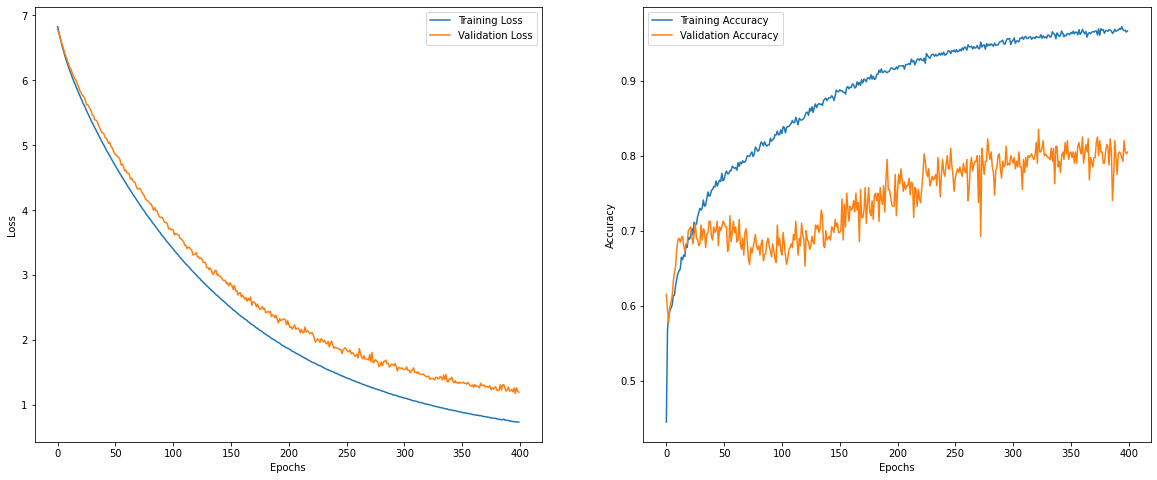

In [43]:
# Plot a graph of the metric vs. epochs.
plot_curve(history)
# # Evaluate on Test & Save results
results.loc['smote'] = list(tuned_model2.evaluate(X_test, y_test))

In [44]:
results

,loss,accuracy
smote,5.492192,0.482143


## Business Metrics

In [118]:
import yfinance as yf

In [133]:
whole_df_x = np.vstack((X_train_df, X_test_df))
whole_df_x.shape

(1679, 11)

In [135]:
predict_x=tuned_model2.predict(whole_df_x) 
predictions=np.argmax(predict_x,axis=1)

53/53 [==============================] - 0s 859us/step


In [168]:
set(predictions)

{0, 1, 2}

In [166]:
df_pred = pd.DataFrame({'pred':predictions}, index=target_1perc.index)
df_pred =df_pred.replace({2:-1})

df_prices = data = yf.download("^GSPC", start="2016-01-04", end="2022-09-02")[['Adj Close']]

pred_ls = []
prev = 0
for i in range(len(df_pred)):
    if df_pred.iloc[i]['pred'] == 0:
        pred_ls.append(prev)
    else:
        prev = df_pred.iloc[i]['pred']
        pred_ls.append(prev)

df_diff = np.log(df_prices /df_prices.shift(1))
df_diff['pred'] = df_pred['pred']
df_diff['pred_new'] = pred_ls
df_diff['benchmark'] = 1
df_diff["Strategy_Returns"] = df_diff["Adj Close"] * df_diff["pred_new"].shift(1)
df_diff["Benchmark_Returns"] = df_diff["Adj Close"] * df_diff["benchmark"].shift(1)

# Group by year
df_diff = df_diff.reset_index()
df_diff['year'] = df_diff['Date'].apply(lambda x: x.year)
matrix = df_diff.groupby('year').mean()
matrix['Strategy_Returns'] = np.exp(matrix['Strategy_Returns']*252)-1
matrix['Benchmark_Returns'] = np.exp(matrix['Benchmark_Returns']*252)-1

# Annual Mean Returns or Expected returns
# expected_stock_annual_return = np.exp(df_diff['Benchmark_Returns'].mean() * 252) - 1 
# expected_strategy_annual_return = np.exp(df_diff['Strategy_Returns'].mean() * 252) - 1 
#expected_target_annual_return = np.exp(df_diff['Target_Returns'].mean() * 252) - 1 
#print(f'Expected Annual Returns: Strategy: {round(expected_strategy_annual_return*100, 2)}%  |  Stock: {round(expected_stock_annual_return*100, 2)}%')

[*********************100%***********************]  1 of 1 completed


In [167]:
matrix

,Adj Close,pred,pred_new,benchmark,Strategy_Returns,Benchmark_Returns
year,,,,,,
2016,0.000424,-0.059524,-0.634921,1.0,-0.150590,0.112846
2017,0.000707,0.011952,0.832669,1.0,0.151247,0.195044
2018,-0.000257,0.107570,-0.059761,1.0,0.264985,-0.062613
2019,0.001007,-0.039683,-0.301587,1.0,-0.080229,0.288781
2020,0.000595,-0.173913,-0.478261,1.0,-0.278270,0.161897
2021,0.000945,-0.095238,-0.603175,1.0,-0.005621,0.268927
2022,-0.001093,-0.047619,-0.880952,1.0,0.472475,-0.240701
